In [4]:
import datetime
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import Model

training_data_path = r"j:\LettersTraining"
testing_data_path = r"j:\LettersTesting"

model_save_path = r"j:\SavedModels"
notebook_save_path = r"J:\SavedNotebooks"

classes = ['A', 'C', 'None', 'R', 'S']

resized_image_size = 64

if not os.path.exists(training_data_path):
    print("Could not find folder: " + training_data_path)
    raise

if not os.path.exists(testing_data_path):
    print("Could not find folder: {}".format(testing_data_path))
    raise

In [5]:
from sklearn.model_selection import train_test_split

training_globs = []
testing_globs = []

num_classes = len(classes)

print("Number of classes: {}".format(num_classes))

for i in range(num_classes):
    training_class_path = os.path.join(training_data_path, classes[i])
    testing_class_path = os.path.join(testing_data_path, classes[i])
    
    training_class_glob = glob(os.path.join(training_class_path, "*.png"))
    testing_class_glob = glob(os.path.join(testing_class_path, "*.png"))
    
    training_globs.append(training_class_glob)
    testing_globs.append(testing_class_glob)

Number of classes: 5


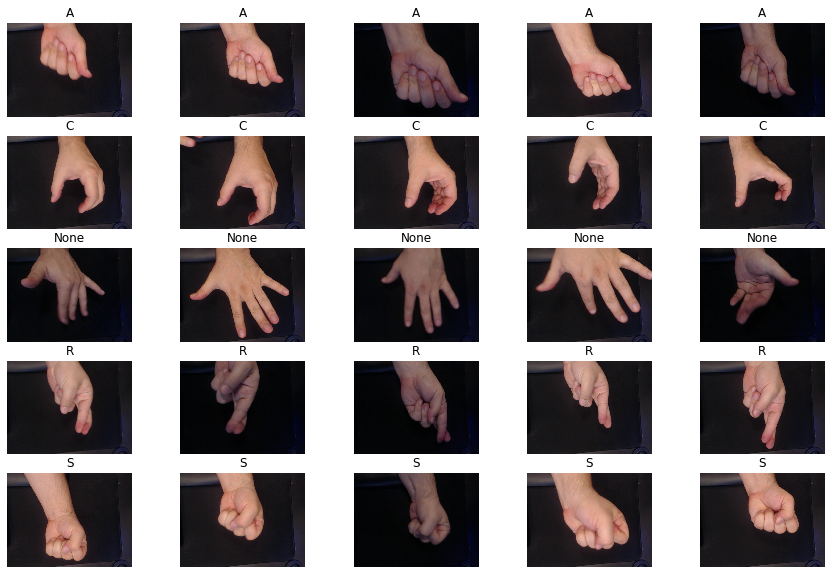

In [6]:
# Show sample images of all classes

num_choices = 5
random_choices = []
labels = []

for i in range(num_classes):
    random_choice = np.random.choice(training_globs[i], num_choices)
    random_choices.append(random_choice)
    labels.append(num_choices * [classes[i]])

plt.figure(figsize=(3*num_choices,2*num_classes))

for class_index in range(num_classes):
    for choice_index in range(num_choices):
        im = Image.open(random_choices[class_index][choice_index]).convert('RGB')
        plt.subplot(num_classes, num_choices, class_index * num_choices + choice_index + 1)
        plt.title(labels[class_index][choice_index])
        plt.imshow(np.asarray(im))
        plt.axis('off')

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = train_datagen.flow_from_directory(
    testing_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 3274 images belonging to 5 classes.
Found 230 images belonging to 5 classes.


In [8]:
def HappyModel():
    X_input = Input(shape = (resized_image_size, resized_image_size, 3), name = 'X_input')
 
    X = Conv2D(8, (3, 3), strides = (1,1) , padding = 'valid')(X_input)
    X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Conv2D(16, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = Conv2D(32, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
    
    X = Conv2D(64, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = Conv2D(128, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Flatten()(X)

    X = Dense(num_classes * 8 + 20, input_shape = (29 * 29 * 16, 1))(X)
    X = Activation('relu')(X)
    X = Dropout(0.4)(X)
 
    X = Dense(num_classes * 4 + 10)(X)
    X = Activation('relu')(X)
 
    X = Dense(num_classes)(X)
    X = Activation('softmax')(X)
    
    return Model([X_input], [X])

model = HappyModel()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxP

In [9]:
num_epochs = 50
steps_per_epoch = int(train_generator.n / batch_size)
validation_steps = int(test_generator.n / batch_size)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

training_time_start = datetime.datetime.now()

history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
102/102 [==============================] - 26s 259ms/step - loss: 0.4385 - acc: 0.8130 - val_loss: 0.3880 - val_acc: 0.8143
Epoch 2/10
102/102 [==============================] - 26s 258ms/step - loss: 0.3123 - acc: 0.8633 - val_loss: 0.2668 - val_acc: 0.8747
Epoch 3/10
102/102 [==============================] - 26s 251ms/step - loss: 0.2501 - acc: 0.8954 - val_loss: 0.1805 - val_acc: 0.9293
Epoch 4/10
102/102 [==============================] - 26s 257ms/step - loss: 0.2179 - acc: 0.9112 - val_loss: 0.1577 - val_acc: 0.9434
Epoch 5/10
102/102 [==============================] - 26s 255ms/step - loss: 0.1799 - acc: 0.9280 - val_loss: 0.1800 - val_acc: 0.9303
Epoch 6/10
102/102 [==============================] - 26s 253ms/step - loss: 0.1635 - acc: 0.9386 - val_loss: 0.0928 - val_acc: 0.9677
Epoch 7/10
102/102 [==============================] - 27s 261ms/step - loss: 0.1379 - acc: 0.9501 - val_loss: 0.1042 - val_acc: 0.9626
Epoch 8

In [10]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-06-10 17:02:12.556053
Training stopped at: 2019-06-10 17:06:33.357270
Total training time: 0:04:20.801217


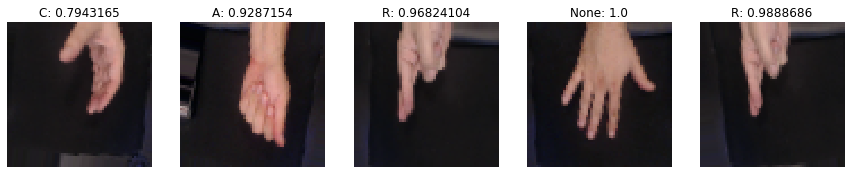

In [13]:
test_generator.reset()
x,y = test_generator.next()

num_choices = 5
test_indices = range(batch_size)

random_choice = np.random.choice(test_indices, num_choices)

plt.figure(figsize=(3*num_choices, 3))

for i in range(num_choices):
    im = x[random_choice[i]][:,:,:]
    prediction = model.predict(np.expand_dims(im, 0))
    plt.subplot(1, num_choices, i+1)
    max_index = np.argmax(prediction[0])
    plt.title(str(classes[max_index]) + ": " + str(prediction[0][max_index]))
    plt.imshow((im + 1)/2)
    plt.axis('off')

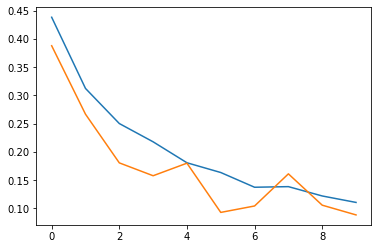

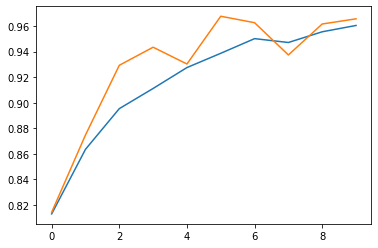

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [17]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
    print("Creating folder: {}".format(model_save_path))

model_file_name = "model_" + timestamp + ".h5"
model_file_fullname = os.path.join(model_save_path, model_file_name)

model.save(model_file_fullname)
print("Model saved to: {}".format(model_file_fullname))

notebook_file_name = "notebook_" + timestamp
notebook_file_fullpath = os.path.join(notebook_save_path, notebook_file_name)

if not os.path.exists(notebook_save_path):
    os.makedirs(notebook_save_path)
    print("Creating folder: {}".format(notebook_save_path))

!jupyter nbconvert --to html TrainHappyModel.ipynb

Model saved to: j:\SavedModels\model_2019-06-10_17-09-55.h5


[NbConvertApp] Converting notebook TrainHappyModel.ipynb to html
[NbConvertApp] Writing 1105671 bytes to TrainHappyModel.html
